In [1]:
#basics
import pandas as pd 
import numpy as np

#misc
import gc
import time
import warnings

#viz
import matplotlib.pyplot as plt
import seaborn as sns

#nlp 
import re   
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer #Tokenizer for preprocessing
from sklearn.model_selection import train_test_split


import gensim.models.keyedvectors as word2vec

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import model_from_json


#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
warnings.filterwarnings("ignore")


%matplotlib inline

Using TensorFlow backend.


In [2]:
data = pd.read_csv('clean_data.csv')
train_df = pd.read_csv('train_df')
val_df = pd.read_csv('val_df')
test_df = pd.read_csv('test_df')
# train = pd.read_csv('train.csv')

In [3]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxic_count
0,7e4ad3cda979a734,ged like penis,0,0,1,0,1,0,2
1,12c82a67010c0fcf,illness nothing time era mental illnesses rea...,0,0,0,0,1,1,2
2,e8577068eb6afd41,do not understand fair use exist,0,0,0,0,0,0,0
3,6b1259718d7da711,please vandalize page edit cause world war ii...,0,0,0,0,0,0,0
4,18608e1b1da6d1a7,bryan holt worst ride operator knott s attenti...,1,0,0,0,0,0,1


In [4]:
# Fill null comment with no commment
processed_comments_data = data["comment_text"].fillna("no commment").tolist()
processed_comments_train = train_df["comment_text"].fillna("no commment").tolist()
processed_comments_val = val_df["comment_text"].fillna("no commment").tolist()
processed_comments_test = test_df["comment_text"].fillna("no commment").tolist()

### Tokenization

In [5]:
max_features = 20000
# initialize tokenizer
tokenizer = Tokenizer(num_words=max_features)
# fit tokenizer on comments, create a dictionary of word index for each comment
tokenizer.fit_on_texts(processed_comments_train)
# transform comments into lists of index/ list of lists of index 
list_tokenized_train = tokenizer.texts_to_sequences(processed_comments_train)
list_tokenized_val = tokenizer.texts_to_sequences(processed_comments_val)
list_tokenized_test = tokenizer.texts_to_sequences(processed_comments_test)

### Padding

Make the shorter sentences as long as the others by filling the shortfall by zeros.
Trim the longer ones to the same length(maxlen=170) as the short ones.

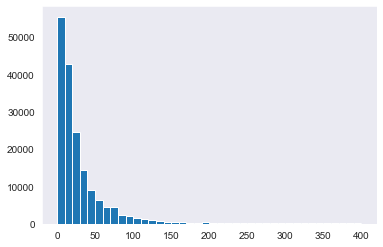

In [6]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400]
plt.show()

*Most of the sentence length is about 30+. We could set the "maxlen" to about 50 but just to be sure of not losing any important information I put maxlen = 170


In [9]:
maxlen = 170
X_train = pad_sequences(list_tokenized_train, maxlen)
X_val = pad_sequences(list_tokenized_val, maxlen)
X_test = pad_sequences(list_tokenized_test, maxlen)
label_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_train = train_df[label_classes].values
y_val = val_df[label_classes].values
y_test = test_df[label_classes].values

# Model

## Baseline Model - LSTM

In [10]:
inp = Input(shape=(maxlen, )) #maxlen=170
embed_size = 128
x = Embedding(max_features, embed_size)(inp)
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

baseline_model = Model(inputs=inp, outputs=x)
baseline_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [11]:
batch_size = 32
epochs = 4
baseline = baseline_model.fit(X_train,y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

Train on 177351 samples, validate on 21110 samples
Epoch 1/4
177351/177351 [==============================] - 649s 4ms/step - loss: 0.1126 - accuracy: 0.9566 - val_loss: 0.1753 - val_accuracy: 0.9298
Epoch 2/4
177351/177351 [==============================] - 610s 3ms/step - loss: 0.0494 - accuracy: 0.9819 - val_loss: 0.2070 - val_accuracy: 0.9332
Epoch 3/4
177351/177351 [==============================] - 629s 4ms/step - loss: 0.0352 - accuracy: 0.9874 - val_loss: 0.3166 - val_accuracy: 0.9267
Epoch 4/4
177351/177351 [==============================] - 632s 4ms/step - loss: 0.0265 - accuracy: 0.9905 - val_loss: 0.3806 - val_accuracy: 0.9217


## Pretrained Embeddings

In [12]:
def load_embedding_matrix(typeToLoad):
    #load different embedding file depending on which embedding 
    #matrix we are going to experiment with
    if(typeToLoad=="glove"):
        EMBEDDING_FILE='glove.twitter.27B.25d.txt'
        embed_size = 25
    elif(typeToLoad=="word2vec"):
        word2vecDict = word2vec.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)
        embed_size = 300
    elif(typeToLoad=="fasttext"):
        EMBEDDING_FILE='wiki.simple.vec'
        embed_size = 300
    
    print(f"LOADING {typeToLoad} | embed_size {embed_size}")

    if(typeToLoad=="glove" or typeToLoad=="fasttext" ):
        embeddings_index = dict()
        #Transfer the embedding weights into a dictionary by iterating through every line of the file.
        f = open(EMBEDDING_FILE)
        for idx, line in enumerate(f):
            #split up line into an indexed array
            values = line.split()
            #first index is word
            word = values[0]
            if len(values) == (embed_size+1):
                #store the rest of the values in the array as a new array
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs #50 dimensions
            elif len(values) > (embed_size+1):
                word = " ".join(values[:2])
                coefs = np.asarray(values[2:], dtype='float32')
                embeddings_index[word] = coefs #50 dimensions
            else:
                coefs = np.asarray(values, dtype='float32')
                embeddings_index[""] = coefs #50 dimensions
                
        f.close()
        print(f'Loaded {len(embeddings_index)} word vectors from {typeToLoad}')
    else:
        embeddings_index = dict()
        for word in word2vecDict.wv.vocab:
            embeddings_index[word] = word2vecDict.word_vec(word)
        print(f'Loaded {len(embeddings_index)} word vectors.')

    #We get the mean and standard deviation of the embedding weights so that we could maintain the 
    #same statistics for the rest of our own random generated weights. 
    all_embs = np.stack(list(embeddings_index.values()))
    emb_mean,emb_std = all_embs.mean(), all_embs.std()

    nb_words = len(tokenizer.word_index)
    #We are going to set the embedding size to the pretrained dimension as we are replicating it.
    #the size will be Number of Words in Vocab X Embedding Size
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))


    #With the newly created embedding matrix, we'll fill it up with the words that we have in both 
    #our own dictionary and loaded pretrained embedding. 
    embeddedCount = 0
    for word, i in tokenizer.word_index.items():
        i-=1
        #then we see if this word is in word2vec/glove/fasttext's dictionary, if yes, get the corresponding weights
        embedding_vector = embeddings_index.get(word)
        #and store inside the embedding matrix that we will train later on.
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
            embeddedCount+=1
    print('total embedded:',embeddedCount,'common words')

    del(embeddings_index)


    #finally, return the embedding matrix
    return embedding_matrix

## Word2Vec

In [13]:
word2vec_embedding_matrix = load_embedding_matrix('word2vec')

LOADING word2vec | embed_size 300
Loaded 3000000 word vectors.
total embedded: 53393 common words


In [14]:
word2vec_embedding_matrix.shape

(143337, 300)

In [15]:
inp = Input(shape=(maxlen, ))
x = Embedding(len(tokenizer.word_index), word2vec_embedding_matrix.shape[1],weights=[word2vec_embedding_matrix],trainable=False)(inp)
x = Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

word2vec_model = Model(inputs=inp, outputs=x)
word2vec_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [16]:
batch_size = 32
epochs = 4
word_2_vec = word2vec_model.fit(X_train,y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

Train on 177351 samples, validate on 21110 samples
Epoch 1/4
177351/177351 [==============================] - 1339s 8ms/step - loss: 0.1561 - accuracy: 0.9413 - val_loss: 0.1987 - val_accuracy: 0.9266
Epoch 2/4
177351/177351 [==============================] - 1269s 7ms/step - loss: 0.0886 - accuracy: 0.9665 - val_loss: 0.1953 - val_accuracy: 0.9282
Epoch 3/4
177351/177351 [==============================] - 1159s 7ms/step - loss: 0.0719 - accuracy: 0.9722 - val_loss: 0.2059 - val_accuracy: 0.9290
Epoch 4/4
177351/177351 [==============================] - 1193s 7ms/step - loss: 0.0641 - accuracy: 0.9752 - val_loss: 0.2191 - val_accuracy: 0.9257


## GloVe

In [17]:
glove_embedding_matrix = load_embedding_matrix('glove')

LOADING glove | embed_size 25
Loaded 1193515 word vectors from glove
total embedded: 69329 common words


In [18]:
inp = Input(shape=(maxlen, ))
x = Embedding(len(tokenizer.word_index), glove_embedding_matrix.shape[1],weights=[glove_embedding_matrix],trainable=False)(inp)
x = Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

glove_model = Model(inputs=inp, outputs=x)
glove_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [20]:
batch_size = 32
epochs = 4
glove = glove_model.fit(X_train,y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

Train on 177351 samples, validate on 21110 samples
Epoch 1/4
177351/177351 [==============================] - 742s 4ms/step - loss: 0.2579 - accuracy: 0.9020 - val_loss: 0.2398 - val_accuracy: 0.9095
Epoch 2/4
177351/177351 [==============================] - 755s 4ms/step - loss: 0.1842 - accuracy: 0.9299 - val_loss: 0.2276 - val_accuracy: 0.9102
Epoch 3/4
177351/177351 [==============================] - 829s 5ms/step - loss: 0.1581 - accuracy: 0.9395 - val_loss: 0.2301 - val_accuracy: 0.9099
Epoch 4/4
177351/177351 [==============================] - 689s 4ms/step - loss: 0.1457 - accuracy: 0.9447 - val_loss: 0.2288 - val_accuracy: 0.9100


## Fasttext

In [21]:
fasttext_embedding_matrix = load_embedding_matrix('fasttext')

LOADING fasttext | embed_size 300
Loaded 110999 word vectors from fasttext
total embedded: 51136 common words


In [23]:
inp = Input(shape=(maxlen, ))
x = Embedding(len(tokenizer.word_index), fasttext_embedding_matrix.shape[1],weights=[fasttext_embedding_matrix],trainable=False)(inp)
x = Bidirectional(LSTM(60, return_sequences=True,name='lstm_layer',dropout=0.1,recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

fasttext_model = Model(inputs=inp, outputs=x)
fasttext_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [24]:
batch_size = 32
epochs = 4
fasttext = fasttext_model.fit(X_train,y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))


Train on 177351 samples, validate on 21110 samples
Epoch 1/4
177351/177351 [==============================] - 992s 6ms/step - loss: 0.1472 - accuracy: 0.9451 - val_loss: 0.1964 - val_accuracy: 0.9232
Epoch 2/4
177351/177351 [==============================] - 1072s 6ms/step - loss: 0.0834 - accuracy: 0.9687 - val_loss: 0.1942 - val_accuracy: 0.9266
Epoch 3/4
177351/177351 [==============================] - 1058s 6ms/step - loss: 0.0691 - accuracy: 0.9734 - val_loss: 0.2034 - val_accuracy: 0.9291
Epoch 4/4
177351/177351 [==============================] - 1159s 7ms/step - loss: 0.0616 - accuracy: 0.9762 - val_loss: 0.2392 - val_accuracy: 0.9285


## Result

In [25]:
all_losses = {}
all_losses['baseline_loss'] = baseline.history['loss']
all_losses['baseline_val_loss'] = baseline.history['val_loss']
all_losses['word2vec_loss'] = word_2_vec.history['loss']
all_losses['word2vec_val_loss'] = word_2_vec.history['val_loss']
all_losses['glove_loss'] = glove.history['loss']
all_losses['glove_val_loss'] = glove.history['val_loss']
all_losses['fasttext_loss'] = fasttext.history['loss']
all_losses['fasttext_val_loss'] = fasttext.history['val_loss']

In [26]:
all_losses

{'baseline_loss': [0.11255344289634575,
  0.04943312466595417,
  0.035204552121739764,
  0.026512925126829637],
 'baseline_val_loss': [0.17528181679296245,
  0.20703847484106364,
  0.31657604401510286,
  0.3806144535795652],
 'word2vec_loss': [0.15607353314776168,
  0.08858937072525101,
  0.07193806465619197,
  0.06410980946851605],
 'word2vec_val_loss': [0.19868534045555986,
  0.1952561329293172,
  0.20585237194270897,
  0.21906461933392138],
 'glove_loss': [0.2579219209702447,
  0.18419073998706928,
  0.15807421008296318,
  0.14565539929225946],
 'glove_val_loss': [0.23984497509427344,
  0.22759841382079982,
  0.2300528782188243,
  0.2287604987564837],
 'fasttext_loss': [0.14721025294773402,
  0.08342651991112364,
  0.06912602685558811,
  0.06156400344660202],
 'fasttext_val_loss': [0.1964283615435429,
  0.1942360444014697,
  0.2034059928526307,
  0.239168855845787]}

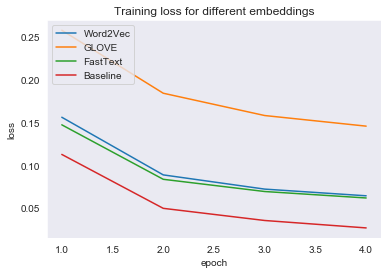

In [27]:
epochRange = np.arange(1,5,1)
plt.plot(epochRange,all_losses['word2vec_loss'])
plt.plot(epochRange,all_losses['glove_loss'])
plt.plot(epochRange,all_losses['fasttext_loss'])
plt.plot(epochRange,all_losses['baseline_loss'])
plt.title('Training loss for different embeddings')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Word2Vec', 'GLOVE','FastText','Baseline'], loc='upper left')
plt.show()

#### Baseline has the minimum training loss.

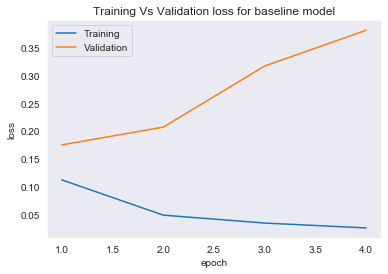

In [28]:
epochRange = np.arange(1,5,1)
plt.plot(epochRange,all_losses['baseline_loss'])
plt.plot(epochRange,all_losses['baseline_val_loss'])
plt.title('Training Vs Validation loss for baseline model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

#### However, overfitting starts at the second epoch as validation loss has become higher than training loss

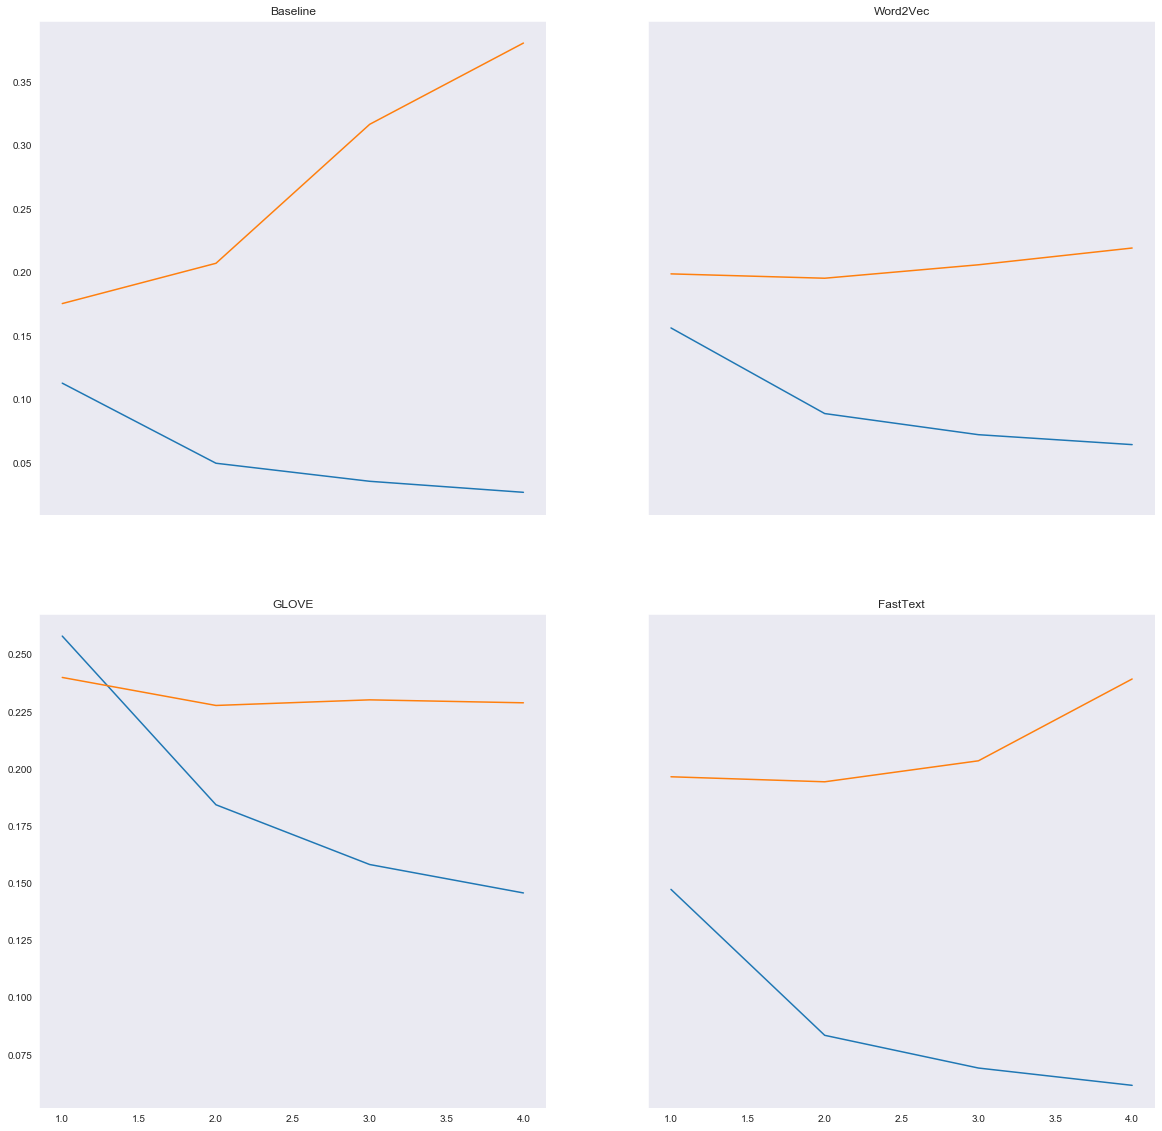

In [32]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row',figsize=(20, 20))

plt.title('Training Vs Validation loss for all embeddings')
ax1.plot(epochRange,all_losses['baseline_loss'])
ax1.plot(epochRange,all_losses['baseline_val_loss'])
ax1.set_title('Baseline')


ax2.plot(epochRange,all_losses['word2vec_loss'])
ax2.plot(epochRange,all_losses['word2vec_val_loss'])
ax2.set_title('Word2Vec')


ax3.plot(epochRange,all_losses['glove_loss'])
ax3.plot(epochRange,all_losses['glove_val_loss'])
ax3.set_title('GLOVE')



ax4.plot(epochRange,all_losses['fasttext_loss'])
ax4.plot(epochRange,all_losses['fasttext_val_loss'])
ax4.set_title('FastText')


plt.show()

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

In [306]:
# y_pred_class = []
# for row in y_pred:
#     y_pred_class.append(np.argmax(row))
# # y_pred_class = np.array(y_pred_class)
# # y_pred_class = np.expand_dims(y_pred_class, axis=1)
# # y_pred_class.shape

In [34]:
def generate_toxic_prediction(y_prob):
    y_pred_col0 = np.where(y_prob[:,0] > 0.4, 1, 0)
    y_pred_col1 = np.where(y_prob[:,1] > 0.5, 1, 0)
    y_pred_col2 = np.where(y_prob[:,3] > 0.3, 1, 0)
    y_pred_col3 = np.where(y_prob[:,3] > 0.6, 1, 0)
    y_pred_col4 = np.where(y_prob[:,4] > 0.5, 1, 0)
    y_pred_col5 = np.where(y_prob[:,5] > 0.5, 1, 0)

    y_pred_col0 = np.expand_dims(y_pred_col0, axis=1)
    y_pred_col1 = np.expand_dims(y_pred_col1, axis=1)
    y_pred_col2 = np.expand_dims(y_pred_col2, axis=1)
    y_pred_col3 = np.expand_dims(y_pred_col3, axis=1)
    y_pred_col4 = np.expand_dims(y_pred_col4, axis=1)
    y_pred_col5 = np.expand_dims(y_pred_col5, axis=1)

    y_pred_colTot = np.concatenate((y_pred_col0, y_pred_col1, y_pred_col2, y_pred_col3, y_pred_col4, y_pred_col5), axis=1)
    return y_pred_colTot


In [39]:
list_classes = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

In [40]:
def show_confusion_matrix(cm_pred):
    fig = plt.figure(figsize = (12,10))
    for i in range(1,7):
        plt.subplot(2,3,i)
        if i%2==0:
            cmap = "Reds"
        else:
            cmap = "Blues"
        sns.set(font_scale=0.8)
        title = f'{list_classes[i-1]}'
        plt.title(title, fontsize = 15)
        sns.heatmap(cm_pred[i-1], cmap=cmap, square=True, fmt='.0f', cbar=False, annot=True)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

In [41]:
baseline_y_prob = baseline_model.predict(X_test,batch_size=1024,verbose=1)
baseline_y_pred = generate_toxic_prediction(baseline_y_prob)

15952/15952 [==============================] - 7s 432us/step


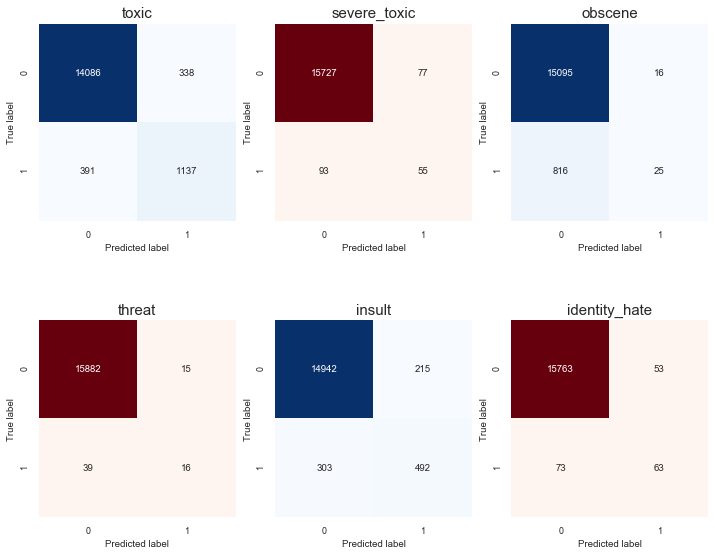

In [42]:
baseline_mcm = multilabel_confusion_matrix(y_test, baseline_y_pred, sample_weight=None, samplewise=False)
show_confusion_matrix(baseline_mcm)

In [43]:
word2vec_y_prob = word2vec_model.predict(X_test,batch_size=1024,verbose=1)
word2vec_y_pred = generate_toxic_prediction(word2vec_y_prob)

15952/15952 [==============================] - 19s 1ms/step


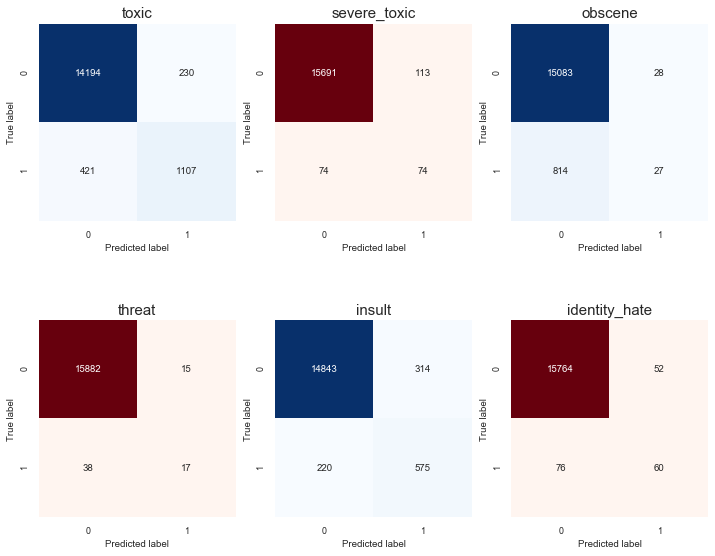

In [44]:
word2vec_mcm = multilabel_confusion_matrix(y_test, word2vec_y_pred, sample_weight=None, samplewise=False)
show_confusion_matrix(word2vec_mcm)

In [45]:
glove_y_prob = glove_model.predict(X_test,batch_size=1024,verbose=1)
glove_y_pred = generate_toxic_prediction(glove_y_prob)

15952/15952 [==============================] - 8s 514us/step


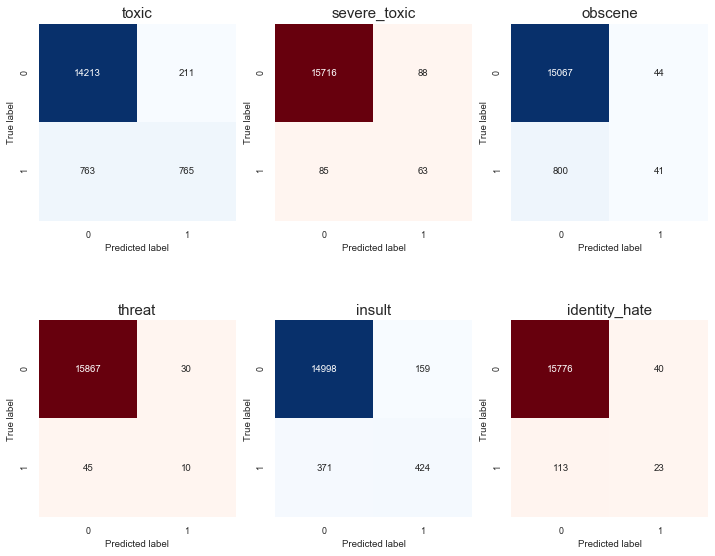

In [46]:
glove_mcm = multilabel_confusion_matrix(y_test, glove_y_pred, sample_weight=None, samplewise=False)
show_confusion_matrix(glove_mcm)

In [47]:
fasttext_y_prob = fasttext_model.predict(X_test,batch_size=1024,verbose=1)
fasttext_y_pred = generate_toxic_prediction(fasttext_y_prob)

15952/15952 [==============================] - 22s 1ms/step


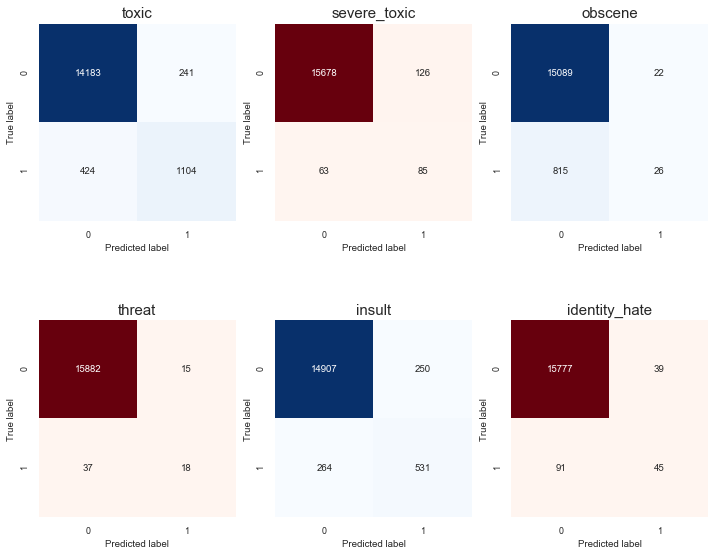

In [48]:
fasttext_mcm = multilabel_confusion_matrix(y_test, fasttext_y_pred, sample_weight=None, samplewise=False)
show_confusion_matrix(fasttext_mcm)

##### Save Models

In [49]:
import h5py
import json

In [50]:
# save model to JSON
baseline_model_json = baseline_model.to_json()
with open("baseline_model.json", "w") as json_file:
    json_file.write(baseline_model_json)
# serialize weights to HDF5
baseline_model.save_weights("baseline_model.h5")
print("Saved model to disk")

Saved model to disk


In [51]:
word2vec_model_json = word2vec_model.to_json()
with open("word2vec_model.json", "w") as json_file:
    json_file.write(word2vec_model_json)
# serialize weights to HDF5
word2vec_model.save_weights("word2vec_model.h5")
print("Saved model to disk")

Saved model to disk


In [52]:
glove_model_json = glove_model.to_json()
with open("glove_model.json", "w") as json_file:
    json_file.write(glove_model_json)
# serialize weights to HDF5
glove_model.save_weights("glove_model.h5")
print("Saved model to disk")

Saved model to disk


In [53]:
fasttext_model_json = fasttext_model.to_json()
with open("fasttext_model.json", "w") as json_file:
    json_file.write(fasttext_model_json)
# serialize weights to HDF5
fasttext_model.save_weights("fasttext_model.h5")
print("Saved model to disk")

Saved model to disk


In [54]:
# load json and create model
# baseline_json_file = open('baseline_model.json', 'r')
# loaded_baseline_model_json = baseline_json_file.read()
# baseline_json_file.close()
# loaded_baseline_model = model_from_json(loaded_baseline_model_json)
# # load weights into new model
# loaded_baseline_model.load_weights("baseline_model.h5")
# print("Loaded model from disk")

In [55]:
# glove_json_file = open('glove_model.json', 'r')
# loaded_glove_model_json = glove_json_file.read()
# glove_json_file.close()
# loaded_glove_model = model_from_json(loaded_glove_model_json)
# # load weights into new model
# loaded_glove_model.load_weights("glove_model.h5")
# print("Loaded model from disk")

In [56]:
# fasttext_json_file = open('fasttext_model.json', 'r')
# loaded_fasttext_model_json = fasttext_json_file.read()
# fasttext_json_file.close()
# loaded_fasttext_model = model_from_json(loaded_fasttext_model_json)
# # load weights into new model
# loaded_fasttext_model.load_weights("fasttext_model.h5")
# print("Loaded model from disk")

### Demo

In [61]:
from nltk.tokenize import RegexpTokenizer #Tokenizer for preprocessing
preprop_tokenizer = RegexpTokenizer(r'\w+')

In [62]:
def clean_text(text, remove_stopwords=True, remove_special_chars=True, remove_contractions=True ,  clean_wiki_tokens=True):
    """Clean the text, with the option to remove stopwords and to stem words."""

    text = text.lower()
    text = re.sub(r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)", "", text)
    text = re.sub(r"(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)){3}", "", text)

    ## Regex to remove wiki special characters
    if clean_wiki_tokens:
        # Drop the image
        text = re.sub(r"image:[a-zA-Z0-9]*\.jpg", " ", text)
        text = re.sub(r"image:[a-zA-Z0-9]*\.png", " ", text)
        text = re.sub(r"image:[a-zA-Z0-9]*\.gif", " ", text)
        text = re.sub(r"image:[a-zA-Z0-9]*\.bmp", " ", text)

        # Drop css
        text = re.sub(r"#([A-Fa-f0-9]{6}|[A-Fa-f0-9]{3})", " ",text)
        text = re.sub(r"\{\|[^\}]*\|\}", " ", text)
        
        # Clean templates
        text = re.sub(r"\[?\[user:.*\]", " ", text)
        text = re.sub(r"\[?\[user:.*\|", " ", text)        
        text = re.sub(r"\[?\[wikipedia:.*\]", " ", text)
        text = re.sub(r"\[?\[wikipedia:.*\|", " ", text)
        text = re.sub(r"\[?\[special:.*\]", " ", text)
        text = re.sub(r"\[?\[special:.*\|", " ", text)
        text = re.sub(r"\[?\[category:.*\]", " ", text)
        text = re.sub(r"\[?\[category:.*\|", " ", text)
    

    # Regex to replace contractions
    if remove_contractions:
        text = re.sub(r"what's", "what is ", text)
        text = re.sub(r"\'s", " ", text)
        text = re.sub(r"\'ve", " have ", text)
        text = re.sub(r"´", "'", text)
        text = re.sub(r"can't", "cannot ", text)
        text = re.sub(r"doesn't", "does not ", text)
        text = re.sub(r"dont't", "do not ", text)
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"i'm", "i am ", text)
        text = re.sub(r"\'re", " are ", text)
        text = re.sub(r"\'d", " would ", text)
        text = re.sub(r"\'ll", " will ", text)
        text = re.sub(r",", " ", text)
        text = re.sub(r"\.", " ", text)
        text = re.sub(r"!", " ! ", text)
        text = re.sub(r"\/", " ", text)
        text = re.sub(r"\?", " ? ", text)
        text = re.sub(r"\!", " ! ", text)
        text = re.sub(r"\"", " ", text)
        text = re.sub(r"\^", " ^ ", text)
        text = re.sub(r"\+", " + ", text)
        text = re.sub(r"\-", " - ", text)
        text = re.sub(r"\=", " = ", text)
        text = re.sub(r"'", " ", text)
        text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
        text = re.sub(r":", " : ", text)
        text = re.sub(r" e g ", " eg ", text)
        text = re.sub(r" b g ", " bg ", text)
        text = re.sub(r" u s ", " american ", text)
        text = re.sub(r"\0s", "0", text)
        text = re.sub(r" 9 11 ", "911", text)
        text = re.sub(r"e - mail", "email", text)
        text = re.sub(r"j k", "jk", text)
        text = re.sub(r"\s{2,}", " ", text)
        # regex to replace all numerics
        replace_numbers = re.compile(r'\d+',re.IGNORECASE)
        text = replace_numbers.sub(" ", text)
    
    # Regex to remove all Non-Alpha Numeric and space
    if remove_special_chars:
        special_character_removal = re.compile(r'[^?!.,:a-z\d ]',re.IGNORECASE)
        text = special_character_removal.sub(' ',text)

    ## Tokenize text and remove stop words
    if remove_stopwords:
        stop_words = set(stopwords.words("english"))
        token_list = preprop_tokenizer.tokenize(text)
        filtered_token_list = [word for word in token_list if word not in stop_words]
        text = " ".join(filtered_token_list).strip()

    return text

In [75]:
def demo(comment,model):
    '''function take in a comment and print out the level of toxic of that comment ''' 
    
    print(f'{comment} \n')
    
    #clean_text
    clean_comment = [clean_text(comment)]
    print(clean_comment)
    #transform: tokenize and padding
    tokenizer.fit_on_texts(clean_comment)
    tokenized_comment = tokenizer.texts_to_sequences(clean_comment)
    pad = pad_sequences(tokenized_comment, max_len)
    #predict
    prob = model.predict(pad,batch_size=24,verbose=1)
    pred = generate_toxic_prediction(prob)
    
    #print out result
    if pred[0][0] == 1:
        print(f'Comment is Toxic')
    if pred[0][1] == 1:
        print('Comment is Severe Toxic')
    if pred[0][2] == 1:
        print('Comment is Obscene')
    if pred[0][3] == 1:
        print('Comment is Threat')
    if pred[0][4] == 1:
        print('Comment is Insult')
    if pred[0][5] == 1:
        print('Comment is Indentity Hate')
    
    #action
    if pred.sum() == 2:
        print(f'Toxic level: {pred.sum()} -> Give Warning.')
    elif pred.sum() >= 3 and pred.sum() < 5:
        print(f'Toxic level: {pred.sum()} -> Give Warning and Human Check.')
    elif pred.sum() >= 5:
        print(f'Toxic level: {pred.sum()} -> Block Account!')
    else:
        print(f'Toxic level: {pred.sum()}')
        


In [76]:
comment1 = "\n\n I was so glad to read... \n\nthis.\n\nAt least there are places in the world that ignore pathetic claims and whining from silly retarded bints with nothing better to do. A bit of rape never hurt anyone anyway. Who the hell do you feminists think you are anyway? Know your place!  —Preceding unsigned comment added by 79.75.179.141   \n\n Rape \n\niz well funny, and is put dem fucking stupid womenz in their places innit. iz wot they is deserve \n\n Jeffpw and Isaac \n\nARE BOTH DEATH\n\nLOL!  —Preceding unsigned comment added by 79.75.179.141   "
comment1

'\n\n I was so glad to read... \n\nthis.\n\nAt least there are places in the world that ignore pathetic claims and whining from silly retarded bints with nothing better to do. A bit of rape never hurt anyone anyway. Who the hell do you feminists think you are anyway? Know your place!  —Preceding unsigned comment added by 79.75.179.141   \n\n Rape \n\niz well funny, and is put dem fucking stupid womenz in their places innit. iz wot they is deserve \n\n Jeffpw and Isaac \n\nARE BOTH DEATH\n\nLOL!  —Preceding unsigned comment added by 79.75.179.141   '

In [78]:
demo(comment1,baseline_model)



 I was so glad to read... 

this.

At least there are places in the world that ignore pathetic claims and whining from silly retarded bints with nothing better to do. A bit of rape never hurt anyone anyway. Who the hell do you feminists think you are anyway? Know your place!  —Preceding unsigned comment added by 79.75.179.141   

 Rape 

iz well funny, and is put dem fucking stupid womenz in their places innit. iz wot they is deserve 

 Jeffpw and Isaac 

ARE BOTH DEATH

LOL!  —Preceding unsigned comment added by 79.75.179.141    

['glad read least places world ignore pathetic claims whining silly retarded bints nothing better bit rape never hurt anyone anyway hell feminists think anyway know place preceding unsigned comment added rape iz well funny put dem fucking stupid womenz places innit iz wot deserve jeffpw isaac death lol preceding unsigned comment added']
1/1 [==============================] - 0s 14ms/step
Comment is Toxic
Toxic level: 1


In [80]:
demo(comment1, fasttext_model)



 I was so glad to read... 

this.

At least there are places in the world that ignore pathetic claims and whining from silly retarded bints with nothing better to do. A bit of rape never hurt anyone anyway. Who the hell do you feminists think you are anyway? Know your place!  —Preceding unsigned comment added by 79.75.179.141   

 Rape 

iz well funny, and is put dem fucking stupid womenz in their places innit. iz wot they is deserve 

 Jeffpw and Isaac 

ARE BOTH DEATH

LOL!  —Preceding unsigned comment added by 79.75.179.141    

['glad read least places world ignore pathetic claims whining silly retarded bints nothing better bit rape never hurt anyone anyway hell feminists think anyway know place preceding unsigned comment added rape iz well funny put dem fucking stupid womenz places innit iz wot deserve jeffpw isaac death lol preceding unsigned comment added']
1/1 [==============================] - 0s 38ms/step
Comment is Toxic
Comment is Insult
Toxic level: 2 -> Give Warning.


In [66]:
comment2 = "AND YOU, YAMLA, CAN BLOW IT OUT OF YOUR BIG FAT ASS!!  DO YOU REALLY THINK THAT I GIVE A FLYING FUCK WHAT YOU DO?  OF COURSE NOT!!!  BAN ME FOR YOU IF YOU MUST!!!!  PROTECT THIS PAGE!!!!!  I WILL NOT BE CENSORED OR SILENCED BY THE LIKES OF YOU, YOU PANSY-ASSED SHIT-EATING MOTHER-FUCKER!!!!!!  I ASSERT MY SECOND AMENDMENT RIGHT OF FREEDOM OF EXPRESSION, AND I FURTHER ASSERT THAT YOU CAN SUCK MY COCK!!!!!!!!\n\n MUHEEHAHAHAHAHAHAHAHAHAH!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!"

In [81]:
demo(comment2, baseline_model)

AND YOU, YAMLA, CAN BLOW IT OUT OF YOUR BIG FAT ASS!!  DO YOU REALLY THINK THAT I GIVE A FLYING FUCK WHAT YOU DO?  OF COURSE NOT!!!  BAN ME FOR YOU IF YOU MUST!!!!  PROTECT THIS PAGE!!!!!  I WILL NOT BE CENSORED OR SILENCED BY THE LIKES OF YOU, YOU PANSY-ASSED SHIT-EATING MOTHER-FUCKER!!!!!!  I ASSERT MY SECOND AMENDMENT RIGHT OF FREEDOM OF EXPRESSION, AND I FURTHER ASSERT THAT YOU CAN SUCK MY COCK!!!!!!!!

 MUHEEHAHAHAHAHAHAHAHAHAH!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 

['yamla blow big fat ass really think give flying fuck course ban must protect page censored silenced likes pansy assed shit eating mother fucker assert second amendment right freedom expression assert suck cock muheehahahahahahahahahah']
1/1 [==============================] - 0s 13ms/step
Comment is Toxic
Toxic level: 1


In [82]:
demo(comment2, fasttext_model)

AND YOU, YAMLA, CAN BLOW IT OUT OF YOUR BIG FAT ASS!!  DO YOU REALLY THINK THAT I GIVE A FLYING FUCK WHAT YOU DO?  OF COURSE NOT!!!  BAN ME FOR YOU IF YOU MUST!!!!  PROTECT THIS PAGE!!!!!  I WILL NOT BE CENSORED OR SILENCED BY THE LIKES OF YOU, YOU PANSY-ASSED SHIT-EATING MOTHER-FUCKER!!!!!!  I ASSERT MY SECOND AMENDMENT RIGHT OF FREEDOM OF EXPRESSION, AND I FURTHER ASSERT THAT YOU CAN SUCK MY COCK!!!!!!!!

 MUHEEHAHAHAHAHAHAHAHAHAH!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 

['yamla blow big fat ass really think give flying fuck course ban must protect page censored silenced likes pansy assed shit eating mother fucker assert second amendment right freedom expression assert suck cock muheehahahahahahahahahah']
1/1 [==============================] - 0s 23ms/step
Comment is Toxic
Toxic level: 1


In [86]:
comment3 = "You are gay or antisemmitian? \n\nArchangel WHite Tiger\n\nMeow! Greetingshhh!\n\nUh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...\n\n1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!\n\n2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!\n\n3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!\n\nBeware of the Dark Side!"

In [89]:
demo(comment3, baseline_model)

You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side! 

['gay antisemmitian archangel white tiger meow greetingshhh uh two ways erased comment ww holocaust brutally slaying jews gays gypsys slavs anyone anti semitian shave head bald go skinhead meetings doubt words bible homosexuality deadly sin make pentagram tatoo forehead go satanistic masses gay pals first last warning fucking gay wo appreciate naz